In [16]:
import numpy as np
from typing import List, Tuple, Optional
import random
from collections import defaultdict
import random
import pickle
import matplotlib.pyplot as plt

In [17]:
class TicTacToeEnv:
    def __init__(self):
        """
        Initializes a new TicTacToe environment.

        Board representation:
        - 0: Empty cell
        - 1: Player X
        - -1: Player O (opponent)

        The board is initialized as a 3x3 matrix of zeros.
        Player X starts the game (represented by 1).
        """
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1

    def reset(self) -> np.ndarray:
        """
        Resets the environment for a new game.

        Returns:
            np.ndarray: A clean 3x3 board filled with zeros
        """
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
        return self.board.copy()

    def get_valid_moves(self) -> List[Tuple[int, int]]:
        """
        Returns all valid moves in the current board state.

        Returns:
            List[Tuple[int, int]]: List of (row, column) tuples representing empty cells
        """
        return [(i, j) for i in range(3) for j in range(3) if self.board[i, j] == 0]

    def make_move(self, position: Tuple[int, int]) -> Tuple[np.ndarray, float, bool]:
        """
        Executes a move on the board and returns the new state.

        Args:
            position: Tuple[int, int] representing (row, column) of the move

        Returns:
            Tuple containing:
            - np.ndarray: New board state
            - float: Reward (-1 for loss, 0 for ongoing, 1 for win)
            - bool: Whether the game is finished

        Raises:
            ValueError: If the move is invalid (cell already occupied)
        """
        if not self._is_valid_move(position):
            raise ValueError("Invalid move: Cell is already occupied")

        self.board[position] = self.current_player

        done = False
        reward = 0

        if self._check_winner() == self.current_player:
            reward = 1
            done = True
        elif self._check_winner() is not None:
            reward = -1
            done = True
        elif len(self.get_valid_moves()) == 0:
            done = True

        self.current_player *= -1
        return self.board.copy(), reward, done

    def _is_valid_move(self, position: Tuple[int, int]) -> bool:
        """
        Checks if a move is valid.

        Args:
            position: Tuple[int, int] representing (row, column) of the move

        Returns:
            bool: True if the cell is empty (0), False otherwise
        """
        return self.board[position] == 0

    def _check_winner(self) -> Optional[int]:
        """
        Checks if there's a winner in the current board state.

        Winning conditions:
        - Three in a row (horizontally)
        - Three in a column (vertically)
        - Three in a diagonal

        Returns:
            Optional[int]:
            - 1 if X wins
            - -1 if O wins
            - None if no winner yet
        """
        for i in range(3):
            if abs(sum(self.board[i,:])) == 3:
                return self.board[i,0]

        for j in range(3):
            if abs(sum(self.board[:,j])) == 3:
                return self.board[0,j]

        if abs(sum(np.diag(self.board))) == 3:
            return self.board[0,0]
        if abs(sum(np.diag(np.fliplr(self.board)))) == 3:
            return self.board[0,2]

        return None

    def render(self):
        """
        Displays the current board state in a human-readable format.

        Output format:
        ---------
        | X | O | X |
        ---------
        | O | X | O |
        ---------
        | X | O | X |
        ---------
        """
        symbols = {0: ' ', 1: 'X', -1: 'O'}
        print('---------')
        for i in range(3):
            print('|', end=' ')
            for j in range(3):
                print(symbols[self.board[i,j]], end=' | ')
            print('\n---------')

In [18]:
def test_environment():
    """
    Demonstrates the functionality of the TicTacToe environment through a sample game.

    This function:
    1. Creates a new environment instance
    2. Executes a predefined sequence of moves
    3. Displays the board state after each move
    4. Shows rewards and game status

    Test sequence:
    - Move (0,0): Top-left corner
    - Move (1,1): Center
    - Move (0,1): Top-middle
    - Move (0,2): Top-right
    - Move (2,2): Bottom-right

    Output for each move:
    - Visual representation of the board
    - Position of the move
    - Reward received (-1, 0, or 1)
    - Whether the game has ended

    The test terminates early if the game ends (win/draw/loss).

    Example output:
    ---------
    | X |   |   |
    ---------
    |   |   |   |
    ---------
    |   |   |   |
    ---------
    Reward: 0, Game ended: False
    """
    # Initialize new environment
    env = TicTacToeEnv()
    print("Initial state:")
    env.render()

    # List of moves to test (row, column)
    moves = [(0,0), (1,1), (0,1), (0,2), (2,2)]

    # Execute each move and display results
    for move in moves:
        print(f"\nMove at position {move}:")
        board, reward, done = env.make_move(move)
        env.render()
        print(f"Reward: {reward}, Game ended: {done}")

        # Stop if game is finished
        if done:
            break

In [19]:
class TicTacToeAgent:
    """
    A Q-learning agent that learns to play Tic-Tac-Toe through reinforcement learning.

    The agent uses an epsilon-greedy policy for action selection and updates its
    Q-values using the Bellman equation.

    Attributes:
        epsilon (float): Exploration rate for epsilon-greedy policy (0-1)
        alpha (float): Learning rate for Q-value updates (0-1)
        gamma (float): Discount factor for future rewards (0-1)
        q_table (defaultdict): Nested dictionary storing Q-values for state-action pairs
    """
    def __init__(self, epsilon: float = 0.1, alpha: float = 0.1, gamma: float = 0.9):
        """
        Initialize the agent with learning parameters.

        Args:
            epsilon: Exploration rate (0.1 = 10% random actions)
            alpha: Learning rate (0.1 = 10% update weight)
            gamma: Discount factor (0.9 = 90% future reward weight)
        """
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        # Dicionário para armazenar valores Q para pares estado-ação
        self.q_table = defaultdict(lambda: defaultdict(float))

    def _get_state_key(self, state: np.ndarray) -> str:
        """
        Convert board state to a string key for Q-table lookup.

        Args:
            state: Current board configuration

        Returns:
            String representation of the board state
        """
        return str(state.tolist())

    def get_action(self, state: np.ndarray, valid_moves: List[Tuple[int, int]]) -> Tuple[int, int]:
        """
        Select an action using epsilon-greedy policy.

        Args:
            state: Current board state
            valid_moves: List of legal moves

        Returns:
            Selected move as (row, column) tuple
        """
        if random.random() < self.epsilon:  # Exploração
            return random.choice(valid_moves)

        # Exploração (escolhe a melhor ação conhecida)
        return self._get_best_action(state, valid_moves)

    def _get_best_action(self, state: np.ndarray, valid_moves: List[Tuple[int, int]]) -> Tuple[int, int]:
        """
        Find the action with highest Q-value for current state.

        Args:
            state: Current board state
            valid_moves: List of legal moves

        Returns:
            Best move as (row, column) tuple. If multiple best moves exist,
            returns one randomly.
        """
        state_key = self._get_state_key(state)
        best_value = float('-inf')
        best_actions = []

        for move in valid_moves:
            value = self.q_table[state_key][str(move)]
            if value > best_value:
                best_value = value
                best_actions = [move]
            elif value == best_value:
                best_actions.append(move)

        return random.choice(best_actions)

    def update(self, state: np.ndarray, action: Tuple[int, int],
               reward: float, next_state: np.ndarray,
               next_valid_moves: List[Tuple[int, int]]):
        """
        Update Q-value for state-action pair using Bellman equation.

        Q(s,a) = Q(s,a) + α[R + γ*max(Q(s',a')) - Q(s,a)]

        Args:
            state: Current state
            action: Taken action
            reward: Received reward
            next_state: Resulting state
            next_valid_moves: Valid moves in next state
        """
        state_key = self._get_state_key(state)
        action_key = str(action)
        next_state_key = self._get_state_key(next_state)

        # Calcula o valor máximo possível no próximo estado
        next_max_value = max([self.q_table[next_state_key][str(move)]
                            for move in next_valid_moves]) if next_valid_moves else 0

        # Atualiza o valor Q usando a equação de Bellman
        current_q = self.q_table[state_key][action_key]
        self.q_table[state_key][action_key] = current_q + self.alpha * (
            reward + self.gamma * next_max_value - current_q
        )

    def save_policy(self, filename: str):
        """Salva a política aprendida em um arquivo"""
        with open(filename, 'wb') as f:
            pickle.dump(dict(self.q_table), f)

    def load_policy(self, filename: str):
        """Carrega uma política salva de um arquivo"""
        with open(filename, 'rb') as f:
            self.q_table = defaultdict(lambda: defaultdict(float), pickle.load(f))

In [20]:
def train_agent(env: TicTacToeEnv, agent: TicTacToeAgent,
                n_episodes: int = 10000, opponent_random_prob: float = 0.5) -> List[float]:
    """
    Train the agent through self-play against a mixed-strategy opponent.

    The opponent alternates between random moves and strategic moves based on
    opponent_random_prob. Training progress is monitored through win rate.

    Args:
        env: TicTacToe environment
        agent: Agent to be trained
        n_episodes: Number of training games
        opponent_random_prob: Probability of opponent making random move

    Returns:
        List of win rates calculated every 100 episodes
    """
    win_rates = []
    wins = 0

    for episode in range(n_episodes):
        state = env.reset()
        done = False

        while not done:
            if env.current_player == 1:
                valid_moves = env.get_valid_moves()
                action = agent.get_action(state, valid_moves)
                next_state, reward, done = env.make_move(action)

                if not done:
                    next_valid_moves = env.get_valid_moves()
                    agent.update(state, action, reward, next_state, next_valid_moves)
                else:
                    agent.update(state, action, reward, next_state, [])
                    if reward == 1:
                        wins += 1

                state = next_state

            else:
                valid_moves = env.get_valid_moves()
                if not done and valid_moves:
                    if random.random() < opponent_random_prob:
                        action = random.choice(valid_moves)
                    else:
                        action = get_best_move(env.board, valid_moves)

                    state, reward, done = env.make_move(action)

        if (episode + 1) % 100 == 0:
            win_rate = wins / 100
            win_rates.append(win_rate)
            wins = 0
            print(f"Episódio {episode + 1}, Taxa de Vitória: {win_rate:.2f}")

    return win_rates

In [21]:
def get_best_move(board: np.ndarray, valid_moves: List[Tuple[int, int]]) -> Tuple[int, int]:
    """
    Implement a simple strategic opponent.

    Strategy priority:
    1. Win if possible
    2. Block opponent from winning
    3. Random move

    Args:
        board: Current board state
        valid_moves: List of legal moves

    Returns:
        Selected move as (row, column) tuple
    """
    for move in valid_moves:
        test_board = board.copy()
        test_board[move] = -1
        if check_winner(test_board) == -1:
            return move

        test_board = board.copy()
        test_board[move] = 1
        if check_winner(test_board) == 1:
            return move

    return random.choice(valid_moves)

In [22]:
def check_winner(board: np.ndarray) -> int:
    """
    Check if there's a winner on the board.

    Args:
        board: Current board state

    Returns:
        1 if X wins
        -1 if O wins
        0 if no winner
    """
    # Verifica linhas
    for i in range(3):
        if abs(sum(board[i,:])) == 3:
            return board[i,0]

    # Verifica colunas
    for j in range(3):
        if abs(sum(board[:,j])) == 3:
            return board[0,j]

    # Verifica diagonais
    if abs(sum(np.diag(board))) == 3:
        return board[0,0]
    if abs(sum(np.diag(np.fliplr(board)))) == 3:
        return board[0,2]

    return 0

In [23]:
def plot_training_results(win_rates: List[float]):
    """
    Visualize training progress through win rate plot.

    Args:
        win_rates: List of win rates over training episodes

    Displays:
        Line plot showing win rate evolution over training
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(win_rates)), win_rates, 'b-')
    plt.xlabel('Centenas de Episódios')
    plt.ylabel('Taxa de Vitória')
    plt.title('Progresso do Treinamento do Agente')
    plt.grid(True)
    plt.show()

A saída de streaming foi truncada nas últimas 5000 linhas.
Episódio 500100, Taxa de Vitória: 0.58
Episódio 500200, Taxa de Vitória: 0.61
Episódio 500300, Taxa de Vitória: 0.45
Episódio 500400, Taxa de Vitória: 0.47
Episódio 500500, Taxa de Vitória: 0.61
Episódio 500600, Taxa de Vitória: 0.51
Episódio 500700, Taxa de Vitória: 0.59
Episódio 500800, Taxa de Vitória: 0.50
Episódio 500900, Taxa de Vitória: 0.55
Episódio 501000, Taxa de Vitória: 0.58
Episódio 501100, Taxa de Vitória: 0.47
Episódio 501200, Taxa de Vitória: 0.54
Episódio 501300, Taxa de Vitória: 0.56
Episódio 501400, Taxa de Vitória: 0.65
Episódio 501500, Taxa de Vitória: 0.59
Episódio 501600, Taxa de Vitória: 0.61
Episódio 501700, Taxa de Vitória: 0.47
Episódio 501800, Taxa de Vitória: 0.58
Episódio 501900, Taxa de Vitória: 0.53
Episódio 502000, Taxa de Vitória: 0.62
Episódio 502100, Taxa de Vitória: 0.51
Episódio 502200, Taxa de Vitória: 0.58
Episódio 502300, Taxa de Vitória: 0.56
Episódio 502400, Taxa de Vitória: 0.62
Episó

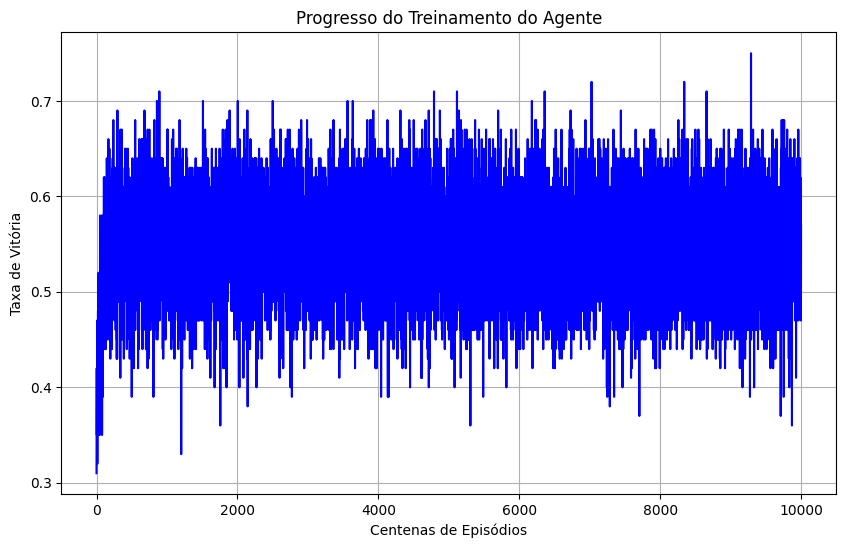

In [24]:
def main():
    """
    Main execution function demonstrating complete training workflow:
    1. Initialize environment and agent
    2. Train agent
    3. Visualize results
    4. Save trained policy
    """
    env = TicTacToeEnv()
    agent = TicTacToeAgent(epsilon=0.1, alpha=0.1, gamma=0.9)

    win_rates = train_agent(env, agent, n_episodes=10000*100, opponent_random_prob=0.5)

    plot_training_results(win_rates)

    agent.save_policy('tic_tac_toe_policy.pkl')

if __name__ == "__main__":
    main()